<a href="https://colab.research.google.com/github/helakhaddar/Graduation_project-Detecting-cyberbullying-using-LLMs-and-sentiment-features/blob/main/Modeling_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## drive and librairies

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Useful functions

In [ ]:
def plot_label_distribution(df, label_column='label'):
    # Map the label column
    df['label'] = df[label_column].map({0: 'Non-cyberbullying', 1: 'Bullying'})

    # Plotting the distribution
    plt.figure(figsize=(6, 4))
    df['label'].value_counts().plot(kind='bar', color=['blue', 'red'])
    plt.title('Distribution of Cyberbullying Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

def plot_distribution_sentimentlabel(df):

  plt.figure(figsize=(3, 3))
  df['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'red'])
  plt.title('Distribution of sentiment Labels ')
  plt.xlabel('sentiment')
  plt.ylabel('Count')
  plt.xticks(rotation=0)
  plt.show()

def plot_relation_sent_label(df):
  sent_label_cross = pd.crosstab(df['Sentiment'], df['label'])
  sent_label_cross['sum'] = sent_label_cross[0.0] + sent_label_cross[1.0]
  sent_label_cross['non bullying tweet %'] = sent_label_cross[0.0]/sent_label_cross['sum']*100
  sent_label_cross['bullying tweet %'] = sent_label_cross[1.0]/sent_label_cross['sum']*100
  sent_label_cross = sent_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

  ax = sent_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
  plt.xlabel('Sentiment')
  plt.ylabel('percentage %')
  plt.title('Relation between sentiment and bullying')
  ax.legend(loc='lower right')
  plt.show()

### Importing librairies

In [ ]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
!pip install transformers==4.30.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [ ]:
# Loading Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import TFBertModel, AutoTokenizer, DistilBertTokenizer
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

## Loading the dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/PFE/Data/merged_data.csv")

In [ ]:
data.head()

,Text,label,Sentiment
0,read contextno change meaning history islamic ...,0,0
1,idiot claim people tried stop becoming terrori...,0,-1
2,call sexist go auto place would rather talk guy,1,0
3,wrong isi follows example mohammed quran exactly,1,-1
4,saudi preacher raped tortured five yearold dau...,0,0


###  Final Data analysis

In [ ]:
data["len"] = [len(text.split()) for text in data.Text]

In [ ]:
data_txt = data[data['len'] < data['len'].quantile(0.995)]

In [ ]:
data_txt.label.value_counts()

,count
label,
1,37775
0,33694


In [ ]:
data.label.value_counts()

,count
label,
1,37782
0,34049


In [ ]:
data_txt.isnull().sum()

,0
Text,0
label,0
Sentiment,0
len,0


In [ ]:
data_txt.isnull().sum()
data_txt.dropna(inplace=True)
data_txt.drop_duplicates(inplace=True)

<ipython-input-10-987d12103bb5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt.dropna(inplace=True)
<ipython-input-10-987d12103bb5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt.drop_duplicates(inplace=True)


<ipython-input-14-41b38ab17881>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df[label_column].map({0: 'Non-cyberbullying', 1: 'Bullying'})


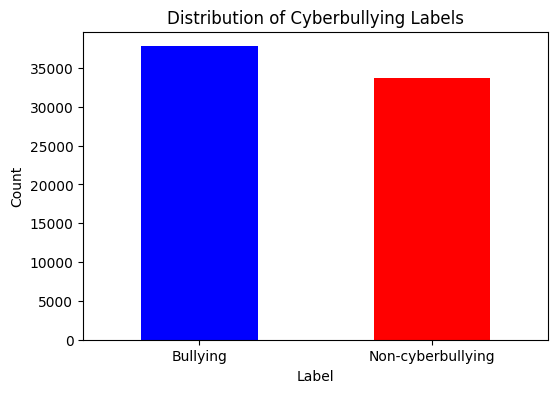

In [ ]:
plot_label_distribution(data_txt)

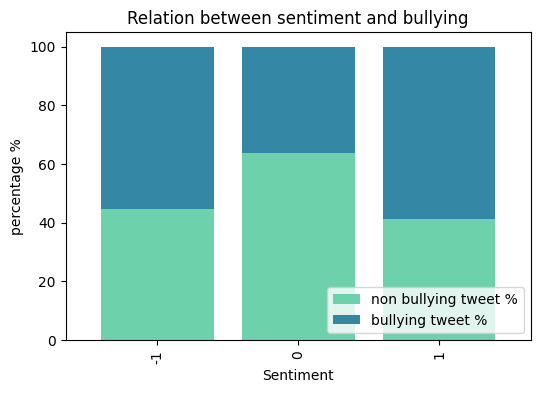

In [ ]:
plot_relation_sent_label(data_txt)

### Splitting the data

In [ ]:
# Separate features and labels
X = data_txt['Text'].values
sentiments = data_txt['Sentiment'].values
y = data_txt['label'].values


In [ ]:
# Split the dataset into training and testing sets
X_train, X_tem, y_train, y_tem, sent_train, sent_tem = train_test_split(X, y, sentiments, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val, sent_test, sent_val = train_test_split(X_tem, y_tem, sent_tem, test_size=0.5, random_state=42, stratify=y_tem)

### Handling the data imbalance with: an oversampling technique and the class weight approach

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#Compute class weights based on original data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Combine X_train and sent_train into a single DataFrame
train_combined = pd.DataFrame({
    'Text': X_train,
    'Sentiment': sent_train
})

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling to the combined data
train_combined_res, y_train_res = ros.fit_resample(train_combined, y_train)

# Separate the resampled data back into X_train_res and sent_train_res
X_train_res = train_combined_res['Text'].values
sent_train_res = train_combined_res['Sentiment'].values

### Data leak verification

In [ ]:
# Convert sets to check for overlap
train_texts = set(X_train)
test_texts = set(X_test)

# Find common entries
common_texts = train_texts.intersection(test_texts)

if len(common_texts) > 0:
    print(f"There are {len(common_texts)} overlapping entries between training and test sets.")
else:
    print("No overlapping entries found between training and test sets.")


No overlapping entries found between training and test sets.


In [ ]:
# Check the distribution of the original dataset
original_distribution = data_txt['label'].value_counts(normalize=True)
print("Original Data Distribution:\n", original_distribution)

# Check the distribution of the training set before and after oversampling
train_distribution_before = pd.Series(y_train).value_counts(normalize=True)
print("Training Data Distribution Before Oversampling:\n", train_distribution_before)

train_distribution_after = pd.Series(y_train_res).value_counts(normalize=True)
print("Training Data Distribution After Oversampling:\n", train_distribution_after)

# Check the distribution of the test set
test_distribution = pd.Series(y_test).value_counts(normalize=True)
print("Test Data Distribution:\n", test_distribution)


Original Data Distribution:
 label
1    0.528551
0    0.471449
Name: proportion, dtype: float64
Training Data Distribution Before Oversampling:
 1    0.528544
0    0.471456
Name: proportion, dtype: float64
Training Data Distribution After Oversampling:
 1    0.5
0    0.5
Name: proportion, dtype: float64
Test Data Distribution:
 1    0.528545
0    0.471455
Name: proportion, dtype: float64


## Tokenization

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
x_train_enc = tokenizer(X_train_res.astype(str).tolist(),  truncation=True, padding='max_length', max_length=128, return_tensors='tf')
x_valid_enc= tokenizer(X_val.astype(str).tolist(), truncation=True, padding='max_length', max_length=128, return_tensors='tf')
x_test_enc = tokenizer(X_test.astype(str).tolist(), truncation=True, padding='max_length', max_length=128, return_tensors='tf')

In [ ]:
# Debugging: Print shapes to verify
print(f"X_train_res_ids shape: {x_train_enc['input_ids'].shape}")
print(f"X_train_res_attention_masks shape: {x_train_enc['attention_mask'].shape}")
print(f"X_test_ids shape: {x_test_enc['input_ids'].shape}")
print(f"X_test_attention_masks shape: {x_test_enc['attention_mask'].shape}")
print(f"X_valid_ids shape: {x_valid_enc['input_ids'].shape}")
print(f"X_valid_attention_masks shape: {x_valid_enc['attention_mask'].shape}")

X_train_res_ids shape: (52884, 128)
X_train_res_attention_masks shape: (52884, 128)
X_test_ids shape: (10720, 128)
X_test_attention_masks shape: (10720, 128)
X_valid_ids shape: (10721, 128)
X_valid_attention_masks shape: (10721, 128)


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
EPOCHS = 5
BATCH_SIZE = 16
MAX_LEN = 128

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({
        'input_word_ids': tf.constant(x_train_enc['input_ids']),
        'input_attention_mask': tf.constant(x_train_enc['attention_mask']),
        'input_sentiment': tf.constant(sent_train_res, dtype=tf.int32)
     } , y_train_res))
    .repeat()
    .shuffle(2048)
    .batch(16)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({
       'input_word_ids': tf.constant(x_valid_enc['input_ids']),
        'input_attention_mask': tf.constant(x_valid_enc['attention_mask']),
        'input_sentiment': tf.constant(sent_val, dtype=tf.int32)
     } , y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)





In [ ]:
# Define a function to print the shapes of the tensors in the dataset
def print_dataset_shapes(dataset, name):
    print(f"Shapes in {name}:")
    for batch in dataset.take(1):  # Take one batch from the dataset
        inputs, labels = batch
        for key, value in inputs.items():
            print(f"{key}: {value.shape}")
        print(f"labels: {labels.shape}")

# Print shapes of train_dataset
print_dataset_shapes(train_dataset, "train_dataset")

# Print shapes of valid_dataset
print_dataset_shapes(valid_dataset, "valid_dataset")

# Print shapes of test_dataset
print_dataset_shapes(test_dataset, "test_dataset")

Shapes in train_dataset:
input_word_ids: (16, 128)
input_attention_mask: (16, 128)
input_sentiment: (16,)
labels: (16,)
Shapes in valid_dataset:
input_word_ids: (16, 128)
input_attention_mask: (16, 128)
input_sentiment: (16,)
labels: (16,)
Shapes in test_dataset:
input_word_ids: (16, 128)
input_attention_mask: (16, 128)
input_sentiment: (16,)
labels: (16,)


In [ ]:
transformer_layer =  transformers.TFBertModel.from_pretrained('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## Modeling

In [ ]:
pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 31.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import tensorflow_addons as tfa

metrics = [
    tfa.metrics.F1Score(num_classes=1, threshold=0.5),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(),

]

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Custom weighted binary cross-entropy
from tensorflow.keras import backend as K

def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Apply weights to the binary crossentropy
        loss = y_true * weights[1] * K.binary_crossentropy(y_true, y_pred) + (1 - y_true) * weights[0] * K.binary_crossentropy(y_true, y_pred)

        return K.mean(loss, axis=-1)
    return loss


In [ ]:
# Define focal loss
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, 'float32')
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (K.ones_like(y_true) - y_pred)
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fixed

In [ ]:
loss_fn = focal_loss(gamma=2., alpha=0.25)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

# Define the model
def build_model(transformer, max_len=192):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_attention_mask")
    input_sentiment = Input(shape=(1,), dtype=tf.int32, name="input_sentiment")

    sequence_output = transformer([input_word_ids, input_attention_mask])[0]
    cls_token = sequence_output[:, 0, :]

    concatenated = Concatenate()([cls_token, tf.cast(input_sentiment, tf.float32)])
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.04))(concatenated)
    x = Dropout(0.6)(x)  # Increase dropout rate
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04))(x)
    x = Dropout(0.6)(x)  # Additional dropout layer
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_attention_mask, input_sentiment], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=loss_fn, metrics=metrics)
    return model

In [ ]:
# Compile the model with custom loss
#loss_fn = weighted_binary_crossentropy(class_weights_dict)
model = build_model(transformer=transformer_layer, max_len=128)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_attention_mask (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_word_ids[0][0]',      
 )                           ngAndCrossAttentions(last_   40         'input_attention_mask[0

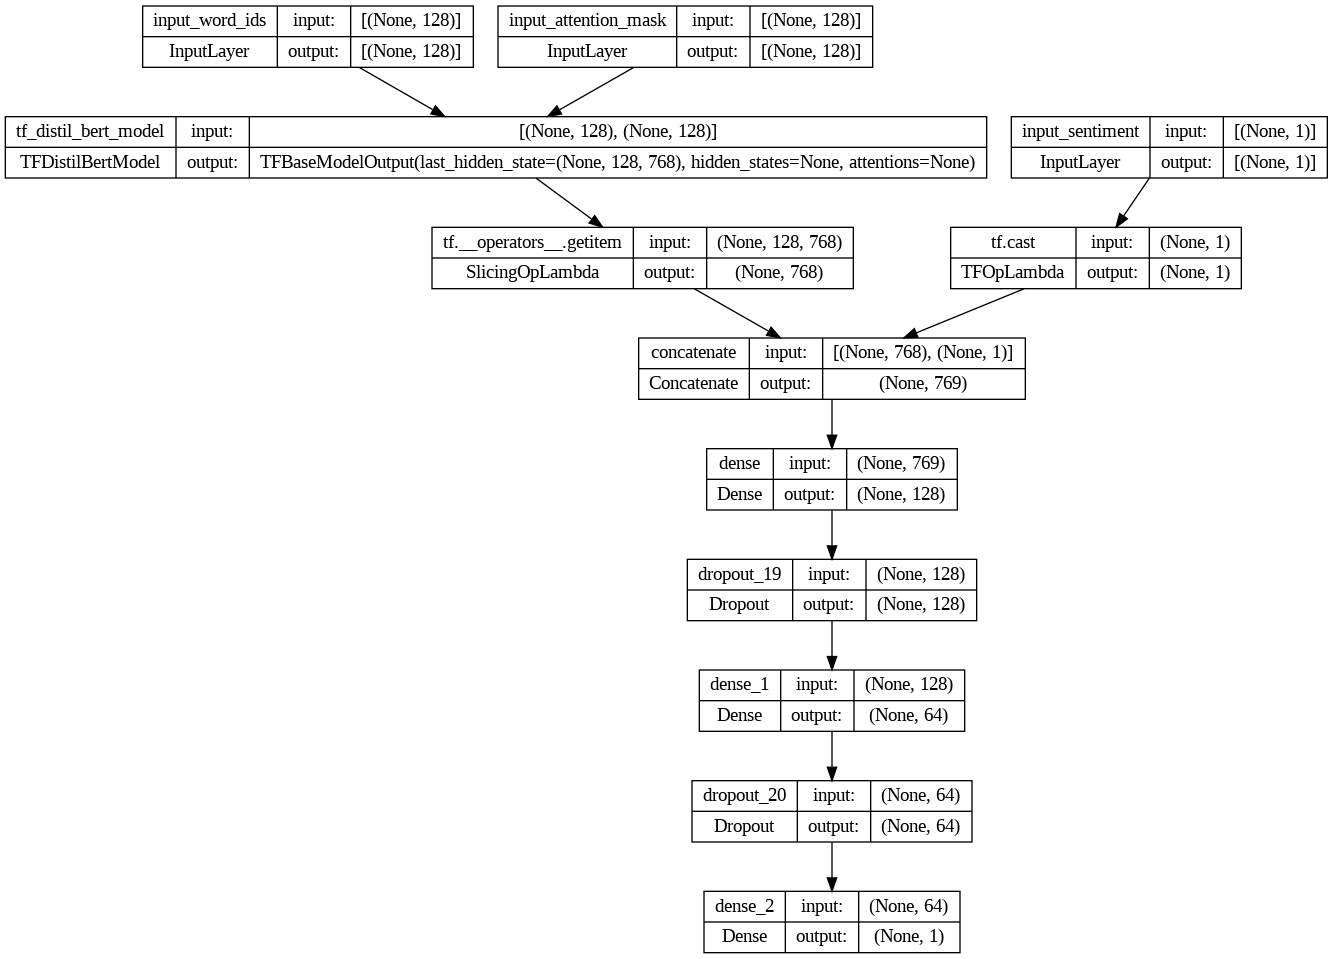

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='modeldistilbert_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

In [ ]:
n_steps = X_train_res.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


3305/3305 [==============================] - 1484s 437ms/step - loss: 7.7901 - f1_score: 0.7670 - accuracy: 0.7989 - precision: 0.9252 - recall: 0.6550 - auc: 0.9131 - val_loss: 4.4030 - val_f1_score: 0.8467 - val_accuracy: 0.8574 - val_precision: 0.9805 - val_recall: 0.7450 - val_auc: 0.9629 - lr: 1.0000e-05
Epoch 2/20
3305/3305 [==============================] - 1445s 437ms/step - loss: 2.6185 - f1_score: 0.8464 - accuracy: 0.8636 - precision: 0.9690 - recall: 0.7513 - auc: 0.9568 - val_loss: 1.3660 - val_f1_score: 0.8477 - val_accuracy: 0.8587 - val_precision: 0.9853 - val_recall: 0.7438 - val_auc: 0.9683 - lr: 1.0000e-05
Epoch 3/20
3305/3305 [==============================] - 1443s 436ms/step - loss: 0.8161 - f1_score: 0.8830 - accuracy: 0.8932 - precision: 0.9759 - recall: 0.8063 - auc: 0.9678 - val_loss: 0.4571 - val_f1_score: 0.8912 - val_accuracy: 0.8928 - val_precision: 0.9618 - val_recall: 0.8302 - val_auc: 0.9684 - lr: 1.0000e-05
Epoch 4/20
3305/3305 [=======================

In [ ]:
#save the model
directory = '/content/drive/MyDrive/PFE/'
model.save(directory + 'FinalModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save_weights('/content/drive/MyDrive/PFE/Finalweights.h5')

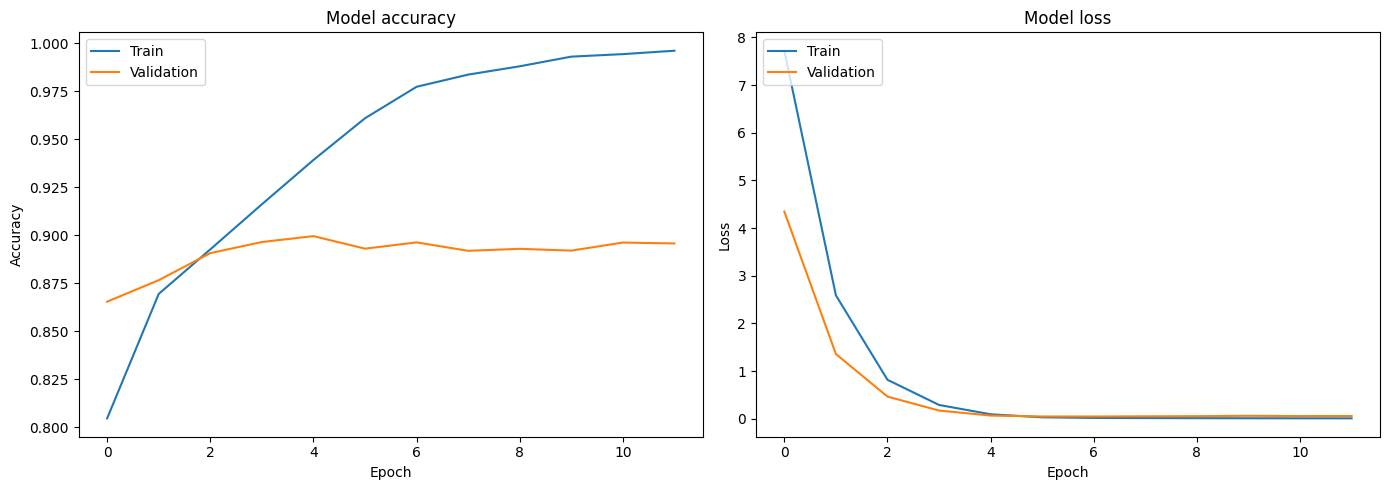

In [ ]:
history = train_history.history

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Evaluation

### Results on our dataset (in-door)



**1. Validation set**

In [ ]:
from sklearn.metrics import classification_report

# Predict on the validation set
y_pred_val = model.predict(valid_dataset)
y_pred_val = (y_pred_val > 0.5).astype(int)

# Generate classification report
report = classification_report(y_val, y_pred_val, target_names=['Not Cyberbullying', 'Cyberbullying'])
print(report)

671/671 [==============================] - 50s 72ms/step
                   precision    recall  f1-score   support

Not Cyberbullying       0.87      0.92      0.89      5054
    Cyberbullying       0.92      0.88      0.90      5667

         accuracy                           0.90     10721
        macro avg       0.90      0.90      0.90     10721
     weighted avg       0.90      0.90      0.90     10721



In [ ]:
results = model.evaluate(valid_dataset)

print("valid Loss:", results[0])
print("valid F1 Score:", results[1])
print("valid Accuracy:", results[2])
print("valid Precision:", results[3])
print("valid Recall:", results[4])

671/671 [==============================] - 50s 75ms/step - loss: 0.0486 - f1_score: 0.8995 - accuracy: 0.8964 - precision: 0.9225 - recall: 0.8777 - auc: 0.9569
valid Loss: 0.0486002191901207
valid F1 Score: [0.8995388]
valid Accuracy: 0.896371603012085
valid Precision: 0.9224777221679688
valid Recall: 0.8777130842208862


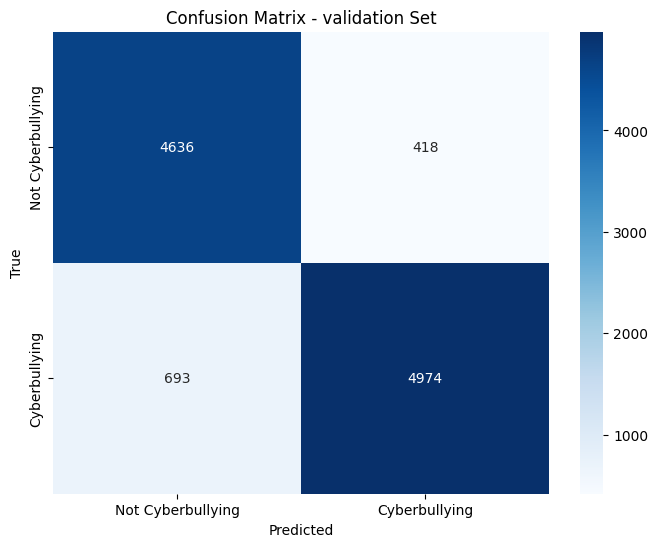

In [ ]:
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix for the validation set
cm_test = confusion_matrix(y_val, y_pred_val)
# Plot the confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cyberbullying', 'Cyberbullying'], yticklabels=['Not Cyberbullying', 'Cyberbullying'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - validation Set')
plt.show()



**2. Test set**

In [ ]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({
        'input_word_ids': tf.constant(x_test_enc['input_ids']),
        'input_attention_mask': tf.constant(x_test_enc['attention_mask']),
        'input_sentiment': tf.constant(sent_test, dtype=tf.int32)
     } , y_test))
    .batch(BATCH_SIZE)
)

In [ ]:
from sklearn.metrics import classification_report

# Predict on the validation set
y_pred_test = model.predict(test_dataset)
y_pred_test = (y_pred_test > 0.5).astype(int)

# Generate classification report
report = classification_report(y_test, y_pred_test, target_names=['Not Cyberbullying', 'Cyberbullying'])
print(report)

670/670 [==============================] - 48s 71ms/step
                   precision    recall  f1-score   support

Not Cyberbullying       0.86      0.92      0.89      5054
    Cyberbullying       0.93      0.87      0.90      5666

         accuracy                           0.89     10720
        macro avg       0.90      0.90      0.89     10720
     weighted avg       0.90      0.89      0.89     10720



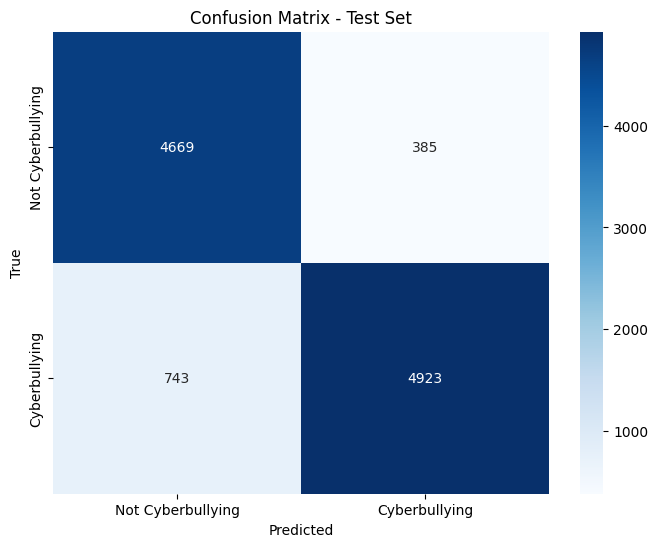

In [ ]:
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix for the validation set
cm_test = confusion_matrix(y_test, y_pred_test)
# Plot the confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cyberbullying', 'Cyberbullying'], yticklabels=['Not Cyberbullying', 'Cyberbullying'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [ ]:
results = model.evaluate(test_dataset)

print("Test Loss:", results[0])
print("Test F1 Score:", results[1])
print("Test Accuracy:", results[2])
print("Test Precision:", results[3])
print("Test Recall:", results[4])

670/670 [==============================] - 50s 74ms/step - loss: 0.0486 - f1_score: 0.8972 - accuracy: 0.8948 - precision: 0.9275 - recall: 0.8689 - auc: 0.9548
Test Loss: 0.04858335852622986
Test F1 Score: [0.89721155]
Test Accuracy: 0.8947761058807373
Test Precision: 0.9274680018424988
Test Recall: 0.8688669204711914


### Results on another complete different dataset:
The data here is from twitter and facebook and the distribution is the inverse of ours where the non_cyberbulliyng class is the majority class

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PFE/Data/evaluation/fb_twitter.csv')
from tensorflow.keras.models import load_model
from transformers import TFDistilBertModel
from tensorflow.keras.utils import custom_object_scope
import tensorflow_addons as tfa

# Define custom objects
custom_objects = {
    'TFDistilBertModel': TFDistilBertModel,
    'Addons>F1Score': tfa.metrics.F1Score,
    'focal_loss_fixed': focal_loss(gamma=2., alpha=0.75)
}

with custom_object_scope(custom_objects):
    model = load_model('/content/drive/MyDrive/PFE/FinalModel.h5')

In [ ]:
data.dropna(inplace=True)

In [ ]:
X = data['cleaned_text'].values.astype(str)
y = data['label'].values
sentiment = data['sentiment'].values

In [ ]:
X_enc = tokenizer(X.tolist(), truncation=True, padding='max_length', max_length=128, return_tensors='tf')

In [ ]:
X_test = X_enc['input_ids']
X_test_attention_masks = X_enc['attention_mask']

In [ ]:
evaluation_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({
        'input_word_ids': tf.constant(X_test),
        'input_attention_mask': tf.constant(X_test_attention_masks),
        'input_sentiment': tf.constant(sentiment, dtype=tf.int32)
    }, y))
    .batch(BATCH_SIZE)
)

In [ ]:
y_evaluate_probs = model.predict(evaluation_dataset)
y_evaluate_probs = y_evaluate_probs.reshape(-1, 1)

879/879 [==============================] - 60s 69ms/step


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y, calibrated_new_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('Optimal Threshold:', optimal_threshold)



Optimal Threshold: 0.232788957023047


In [ ]:
calibrated_new_probs = platt_model.predict_proba(y_evaluate_probs)[:, 1]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, brier_score_loss

# Example metrics
accuracy = accuracy_score(y, calibrated_new_probs.round())
f1 = f1_score(y, calibrated_new_probs.round(), average='weighted')
precision = precision_score(y, calibrated_new_probs.round(), average='weighted')
recall = recall_score(y, calibrated_new_probs.round(), average='weighted')
brier_score = brier_score_loss(y, calibrated_new_probs)

# Print evaluation metrics
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Brier Score:', brier_score)

Accuracy: 0.7492533067842412
F1 Score: 0.7484289904206519
Precision: 0.7476199233666777
Recall: 0.7492533067842412
Brier Score: 0.17676097409981253


In [ ]:
y_pred_test = (calibrated_new_probs > 0.23).astype(int)

                   precision    recall  f1-score   support

Not Cyberbullying       0.86      0.67      0.75     11363
    Cyberbullying       0.28      0.54      0.37      2699

         accuracy                           0.64     14062
        macro avg       0.57      0.60      0.56     14062
     weighted avg       0.75      0.64      0.68     14062



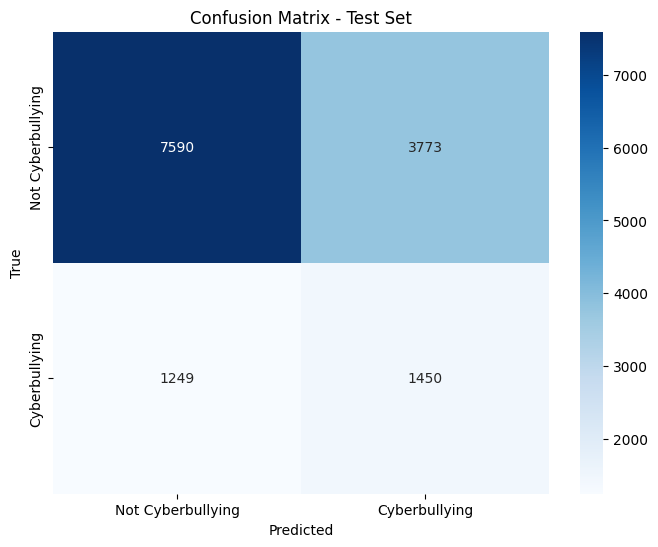

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Generate the confusion matrix
cm_test = confusion_matrix(y, y_pred_test)

# Print classification report
report_test = classification_report(y, y_pred_test, target_names=['Not Cyberbullying', 'Cyberbullying'])
print(report_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cyberbullying', 'Cyberbullying'], yticklabels=['Not Cyberbullying', 'Cyberbullying'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()